In [9]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from functools import partial
from multiprocessing import Pool
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import RepeatedKFold
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

%matplotlib inline
%config IPCompleter.greedy=True
plt.rcParams["figure.figsize"] = (14, 8)

      N   T  MSE  STD
0   138   8  0.0  0.0
1    88   4  0.0  0.0
2    57  10  0.0  0.0
3   124   8  0.0  0.0
4    12   1  0.0  0.0
5   103   3  0.0  0.0
6    41  11  0.0  0.0
7    62   7  0.0  0.0
8   154   4  0.0  0.0
9    47   8  0.0  0.0
10   22   8  0.0  0.0
11  118  11  0.0  0.0
12   23   0  0.0  0.0
13   68   9  0.0  0.0
14   18  11  0.0  0.0
15  112  11  0.0  0.0
16  138   4  0.0  0.0
17   91   4  0.0  0.0
18  138   3  0.0  0.0
19   56   7  0.0  0.0
{'T_Max': 12, 'proc': 3, 'Y': 'ch4_flux', 'epochs': 1000, 'reps': 50, 'Searches': 10, 'N_Max': 200}


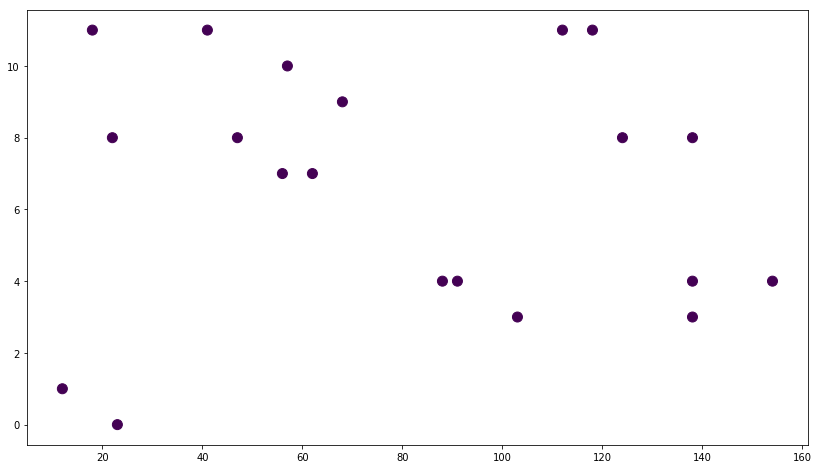

In [10]:
class Params:
    def __init__(self,Func,Y):
        if Func == 'Full':
            epochs = 1000
            reps = 50
            N_Max = 200
            T_Max = 12
            samp_size = 20
            Searches = 10
        else:
            epochs = 10
            reps = 9
            N_Max = 100
            T_Max = 5
            samp_size = 5
            Searches = 2
        N = np.array(np.random.rand(samp_size)*(N_Max-1)+1,dtype='int32')
        T = np.array(np.random.rand(samp_size)*T_Max,dtype='int32')
        d = {'N':N,'T':T}
        self.Runs = pd.DataFrame(data=d)
        self.params = {}
        self.params['T_Max'] = T_Max
        self.params['N_Max'] = N_Max
        self.params['reps'] = reps
        self.params['epochs'] = epochs
        self.params['Y'] = Y
        self.params['proc']=3
        self.params['Searches']=Searches

rpms = Params('Full','ch4_flux')
# rpms = Params('Test',5,'ch4_flux')
Runs,params = rpms.Runs,rpms.params
Runs['MSE'] = 0.0
Runs['STD'] = 0.0
print(Runs)
print(params)
plt.figure()
plt.scatter(Runs["N"],Runs['T'],s=100,c=Runs['MSE'])

In [11]:
class ReadStandardTime:
    def __init__(self,Path):
        self.Master = pd.read_csv(Path,delimiter = ',',header = 0,na_values = -9999)
        self.Master = self.Master.set_index(pd.DatetimeIndex(pd.to_datetime(self.Master['datetime'])))
        self.Master['DOY'] = self.Master.index.dayofyear*1.0
        self.Master['HR'] = self.Master.index.hour*1.0
        
    def Scale(self,y_var,X_vars):
        self.y_var = y_var
        self.Data = self.Master[np.isfinite(self.Master[y_var])]
        self.Data = self.Data.interpolate().bfill()
        self.Data = self.Data.interpolate().ffill()
        self.y = self.Data[y_var].values
        YStandard = StandardScaler()
        self.YScaled = YStandard.fit(self.y.reshape(-1, 1))
        Yscale = self.YScaled.transform(self.y.reshape(-1, 1))
        self.y = np.ndarray.flatten(Yscale)
        self.Ytru = self.YScaled.inverse_transform(self.y.reshape(-1,1))
        X = self.Data[X_vars]
        self.input_shape = len(X_vars)
        XStandard = StandardScaler()
        self.XScaled= XStandard.fit(X)
        self.X = self.XScaled.transform(X)
        Filling = self.Master[X_vars]
        Filling = Filling.interpolate().bfill()
        Filling = Filling.interpolate().ffill()
        XStandard = StandardScaler()
        self.XFillScaled= XStandard.fit(Filling)
        self.X_fill = self.XScaled.transform(Filling)
        
    def TimeShape(self,rolls):
        X1 = self.X
        Xf = self.X_fill
        self.X_time = np.zeros(shape = (X1.shape[0],rolls+1,X1.shape[1]))
        self.X_time[:,0,:] = X1
        self.X_ftime = np.zeros(shape = (Xf.shape[0],rolls+1,Xf.shape[1]))
        self.X_ftime[:,0,:] = Xf
        if rolls > 0:
            for roll in range(0,rolls):
                X2 = np.roll(X1,(roll+1),axis=0)
                X2f = np.roll(Xf,(roll+1),axis=0)
                self.X_time[:,roll+1,:] = X2
                self.X_ftime[:,roll+1,:] = Xf
        self.X_time = self.X_time[rolls+1:,:,:]
        self.X_ftime = self.X_ftime[rolls+1:,:,:]
        self.y_time = self.y[rolls+1:]
        self.y_ftime = self.y[rolls+1:]
        self.TimeSteps = rolls+1
        
    def Fill(self,Y_Pred):
        Y_fill = self.YScaled.inverse_transform(Y_Pred.reshape(-1,1))
        nanz = np.zeros(shape=(self.TimeSteps,1))
        nanz[:,:] = np.nan
        Y_Pred = np.concatenate((nanz,Y_fill),axis=0).reshape(-1,1)
        self.Master['TempFIll'] = Y_Pred
        self.Master[self.y_var+'_Filled'] = self.Master[self.y_var].fillna(self.Master['TempFIll'])

In [12]:
def LSTM_Model(Neurons,batch_size,time_steps,inputs,lr=1e-4,Memory=.9):
    import keras
    from keras.models import Sequential
    from keras.layers import Dense
    from keras.layers import LSTM
    from keras.wrappers.scikit_learn import KerasRegressor
    from keras.callbacks import EarlyStopping,ModelCheckpoint,LearningRateScheduler
#     from keras import backend as K
    import tensorflow as tf
    config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = Memory
    session = tf.Session(config=config)
    model = Sequential()
    model.add(LSTM(Neurons, input_shape=(time_steps,inputs),stateful = False))
    model.add(Dense(1))
    NUM_GPU = 1 # or the number of GPUs available on your machine
    
    adam = keras.optimizers.Adam(lr = lr)
    gpu_list = []
    for i in range(NUM_GPU): gpu_list.append('gpu(%d)' % i)
    model.compile(loss='mean_squared_error', optimizer='adam')#,context=gpu_list) # - Add if using MXNET
    return(model)

def Train_Steps(epochs,Neurons,X_train,X_test,X_val,y_train,y_test,y_val,i,Memory=None):
    
    np.random.seed(i)
    from keras import backend as K
#     epochs = 100
    Scorez=[]
    lr = 1e-3
    Mod = LSTM_Model(Neurons,X_train.shape[0],X_train.shape[1],X_train.shape[2],lr=lr,Memory=Memory)
    killscore=0
    killmax = 10
    e = 0
    udate = 3
    while killscore < killmax and e < epochs:
        Mod.fit(X_train,y_train,batch_size=X_train.shape[0], nb_epoch=1,shuffle=True,verbose=0)
        old_weights = Mod.get_weights()
        Y = Mod.predict(X_test,batch_size =X_test.shape[0])
        score = metrics.mean_squared_error(y_test,Y)
        Scorez.append(score)
        if e == 0:
            score_min=score
            min_weights=old_weights
        elif score < score_min:
            score_min = score
            min_weights=old_weights
            killscore = 0
        else:
            killscore +=1
        if killscore == math.floor(killmax/2):
            K.set_value(Mod.optimizer.lr, 0.5 * K.get_value(Mod.optimizer.lr))
        Mod.reset_states()
        e +=1
    Mod.set_weights(min_weights)
    Yval = Mod.predict(X_val,batch_size = X_val.shape[0])
    MSE = (metrics.mean_squared_error(y_val,Yval))
    Scorez=np.asanyarray(Scorez)
    return(MSE)
           

In [13]:
def TTV_Split(i,Memory,X,y,params):
    X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.1, random_state=i)
    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train, test_size=0.11, random_state=i)
    return(Train_Steps(params['epochs'],params['N'],X_train,X_test,X_val,y_train,y_test,y_val,i=i,Memory=Memory))

# Model = ['Temp_2_5_1','u*','air_pressure','Table_1']#,'NR_Wm2_Avg','AirTC_Avg','RH','DOY']

Model = ["DOY","H","air_pressure","wind_speed","wind_dir","u*","Hz","AirTC_Avg","RH_Samp","Rain_mm_Tot","NR_Wm2_Avg",
         "PPFD_Avg","Temp_2_5_1","Temp_15_1","Temp_5_1","Temp_2_5_2","Temp_15_2","Temp_5_2","Depth_1","Active_Layer_1",
         "Table_1","Depth_2","Active_Layer_2"]



Time = time.time()

Path = 'FI_Data.csv' 
def RunReps(Model,Runs,params,pool = None):
    RST = ReadStandardTime(Path)
    offset = 5/params['proc']
    Memory = (math.floor(100/params['proc'])- offset) * .01
    MSE = []
    RST.Scale(params['Y'],Model)
    RST.TimeShape(params['T'])
    y = RST.y_time*1.0
    X = RST.X_time*1.0
    MSE = []
    if __name__=='__main__'and params['proc'] != 1:
        for i,mse in enumerate(pool.imap(partial(TTV_Split,Memory=Memory,X=X,y=y,params=params),range(params['reps']))):
            MSE.append(mse)
    else:
        for i in range(params['reps']):
            mse = TTV_Split(i,Memory,X,y,params)
            MSE.append(mse)
    MSE = np.asanyarray(MSE)
    return(MSE)
    

if __name__=='__main__'and params['proc'] != 1:
    pool = Pool(processes=params['proc'],maxtasksperchild=75)
else:pool=None
    

for i in Runs.index:
    params['T']=Runs['T'].iloc[i]
    params['N']=Runs['N'].iloc[i]
    MSE = RunReps(Model,Runs,params,pool)#RunFunc(i,processes=processes,Modz=Model,reps=reps,epochs=epochs,params=Runs)
    Runs['MSE'][i]=MSE.mean()
    Runs['STD'][i]=MSE.std()
    print('Finisehd Run ',str(i))
    print(' Stats: ')
    print(Runs.iloc[i])

print(Runs)
  
print(time.time()-Time)
        

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Finisehd Run  0
 Stats: 
N      138.000000
T        8.000000
MSE      0.265532
STD      0.053946
Name: 0, dtype: float64
Finisehd Run  1
 Stats: 
N      88.000000
T       4.000000
MSE     0.251054
STD     0.058566
Name: 1, dtype: float64
Finisehd Run  2
 Stats: 
N      57.000000
T      10.000000
MSE     0.259780
STD     0.051455
Name: 2, dtype: float64
Finisehd Run  3
 Stats: 
N      124.000000
T        8.000000
MSE      0.285038
STD      0.127252
Name: 3, dtype: float64


Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Finisehd Run  4
 Stats: 
N      12.000000
T       1.000000
MSE     0.245540
STD     0.040256
Name: 4, dtype: float64
Finisehd Run  5
 Stats: 
N      103.000000
T        3.000000
MSE      0.245808
STD      0.049314
Name: 5, dtype: float64
Finisehd Run  6
 Stats: 
N      41.000000
T      11.000000
MSE     0.261419
STD     0.060302
Name: 6, dtype: float64
Finisehd Run  7
 Stats: 
N      62.000000
T       7.000000
MSE     0.264501
STD     0.081605
Name: 7, dtype: float64


Using TensorFlow backend.


Finisehd Run  8
 Stats: 
N      154.000000
T        4.000000
MSE      0.263884
STD      0.070576
Name: 8, dtype: float64


Using TensorFlow backend.
Using TensorFlow backend.


Finisehd Run  9
 Stats: 
N      47.000000
T       8.000000
MSE     0.252150
STD     0.038945
Name: 9, dtype: float64
Finisehd Run  10
 Stats: 
N      22.000000
T       8.000000
MSE     0.261020
STD     0.047607
Name: 10, dtype: float64
Finisehd Run  11
 Stats: 
N      118.000000
T       11.000000
MSE      0.255520
STD      0.036351
Name: 11, dtype: float64
Finisehd Run  12
 Stats: 
N      23.000000
T       0.000000
MSE     0.233444
STD     0.031446
Name: 12, dtype: float64


Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Finisehd Run  13
 Stats: 
N      68.000000
T       9.000000
MSE     0.261910
STD     0.070928
Name: 13, dtype: float64
Finisehd Run  14
 Stats: 
N      18.000000
T      11.000000
MSE     0.275111
STD     0.051076
Name: 14, dtype: float64
Finisehd Run  15
 Stats: 
N      112.000000
T       11.000000
MSE      0.265951
STD      0.041010
Name: 15, dtype: float64
Finisehd Run  16
 Stats: 
N      138.000000
T        4.000000
MSE      0.269353
STD      0.089114
Name: 16, dtype: float64


Using TensorFlow backend.


Finisehd Run  17
 Stats: 
N      91.000000
T       4.000000
MSE     0.259399
STD     0.068176
Name: 17, dtype: float64


Using TensorFlow backend.
Using TensorFlow backend.


Finisehd Run  18
 Stats: 
N      138.000000
T        3.000000
MSE      0.250449
STD      0.050938
Name: 18, dtype: float64
Finisehd Run  19
 Stats: 
N      56.000000
T       7.000000
MSE     0.246218
STD     0.048888
Name: 19, dtype: float64
      N   T       MSE       STD
0   138   8  0.265532  0.053946
1    88   4  0.251054  0.058566
2    57  10  0.259780  0.051455
3   124   8  0.285038  0.127252
4    12   1  0.245540  0.040256
5   103   3  0.245808  0.049314
6    41  11  0.261419  0.060302
7    62   7  0.264501  0.081605
8   154   4  0.263884  0.070576
9    47   8  0.252150  0.038945
10   22   8  0.261020  0.047607
11  118  11  0.255520  0.036351
12   23   0  0.233444  0.031446
13   68   9  0.261910  0.070928
14   18  11  0.275111  0.051076
15  112  11  0.265951  0.041010
16  138   4  0.269353  0.089114
17   91   4  0.259399  0.068176
18  138   3  0.250449  0.050938
19   56   7  0.246218  0.048888
6008.299901485443


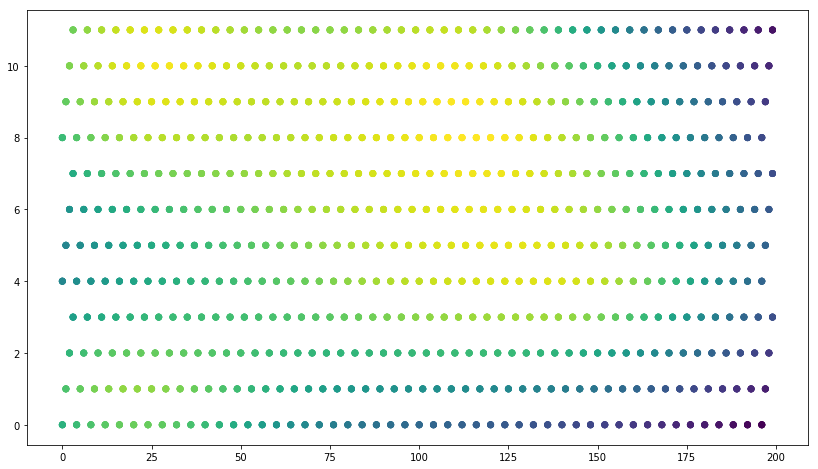

In [14]:
from scipy.stats import norm

plt.rcParams["figure.figsize"] = (14, 8)
def probability_of_improvement(mu_x, sigma_x, opt_value, kappa=0.5):
    gamma_x = (mu_x - opt_value - kappa) / sigma_x
    return norm.cdf(gamma_x)


def expected_improvement(mu_x, sigma_x, opt_value, kappa=0.5):
    gamma_x = (mu_x - opt_value - kappa) / sigma_x
    return sigma_x * (gamma_x * norm.cdf(gamma_x) + norm.pdf(gamma_x))


def upper_confidence_bound(mu_x, sigma_x, opt_value, kappa=-1.0):
    return mu_x + kappa * sigma_x

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel

kernel = Matern(length_scale = [50,3],length_scale_bounds="fixed")
gp = GaussianProcessRegressor(kernel=kernel, alpha=Runs['STD'].values, random_state=0,normalize_y=False)
gp.fit(Runs[['N','T']].values, Runs['MSE'].values)


N = [n for n in range(params['N_Max'])]
T = [t for t in range(params['T_Max'])]
A = [T[i] for j in range(len(N))for i in range(len(T))]
B = [N[i] for j in range(len(T))for i in range(len(N))]
T = np.asanyarray(A)
N = np.asanyarray(B)

X = np.zeros(shape=(T.shape[0],2))
X[:,0] = N
X[:,1] = T
y_pred,sigma = gp.predict(X,return_std=True)

plt.figure()
plt.scatter(X[:,0],X[:,1],c=y_pred)
plt.legend()
Runs2 = Runs.copy()

In [15]:
from scipy.optimize import minimize
acq = upper_confidence_bound
def query(xi, yi, gp):
    best_value = np.inf

    for N in np.linspace(1,params['N_Max']):
        for T in np.linspace(0,params['T_Max']):
            def obj(x):
                x=x.reshape(1,-1)
                mu_x, sigma_x = gp.predict(x, return_std=True)
#                 print(np.min(yi),np.max(yi))
                return acq(mu_x, sigma_x, np.min(yi))
            x0 = np.asanyarray([N,T]).reshape(1,2)
            res = minimize(obj, x0, bounds=((1, params['N_Max']),(0,params['T_Max'])))

            if res.fun < best_value:
                best_value = res.fun
                query_point = res.x
    query_point = query_point
    return query_point

for i in range(params['Searches']):
    kernel = Matern(length_scale_bounds="fixed") 
    gp = GaussianProcessRegressor(kernel=kernel, alpha=Runs['STD'].values, random_state=1,normalize_y=True)
    gp.fit(Runs[['N','T']].values, Runs['MSE'].values)
    
    next_x = query(Runs[['N','T']].values, Runs['MSE'].values, gp)
    print(next_x)
    N = int(np.round(next_x[0],0))
    T = int(np.round(next_x[1],0))
    o = 0
    while len(Runs.loc[(Runs['N']==N) & (Runs['T']==T)].index) != 0:
        print('Adjust!')
        o +=1
        N += int(o*np.cos(o*np.pi))
    print(N,T)
    d = {'N':N,'T':T,'MSE':0,'STD':0}
    idx = Runs.index[-1] + 1
    D2 = pd.DataFrame(data=d,index=[idx])
    Runs = Runs.append(D2)
    
    MSE = RunReps(Model,Runs,params,pool)#RunFunc(i,processes=processes,Modz=Model,reps=reps,epochs=epochs,params=Runs)
    print(MSE)
    Runs['MSE'][idx]=MSE.mean()
    Runs['STD'][idx]=MSE.std()
    
    Runs = Runs.sort_values(by = ['N','T']).reset_index(drop=True)
    
print(Runs)

if __name__=='__main__'and params['proc'] != 1:
    pool.close()

[  1.97901490e+01   4.23494672e-04]
20 0
[ 0.21177887  0.21131592  0.20747429  0.30869742  0.24463725  0.20939951
  0.21131697  0.22525142  0.23189131  0.20327461  0.21404716  0.19858642
  0.21731531  0.39580684  0.27372021  0.24368164  0.18704541  0.25796535
  0.24466413  0.26679525  0.25557899  0.2450095   0.3008768   0.17292556
  0.19356081  0.28814628  0.21271096  0.28963649  0.17633883  0.16736452
  0.27141757  0.28404523  0.25209824  0.26668019  0.20886496  0.31128897
  0.21309478  0.23832529  0.27159711  0.28210969  0.20801508  0.37787476
  0.2132098   0.25479162  0.27877922  0.20257025  0.22952041  0.24689867
  0.18719102  0.27369837]
[ 21.85838692   3.01789632]
22 3
[ 0.21420418  0.21207327  0.20768184  0.30578686  0.24465937  0.2088044
  0.21077723  0.22548497  0.23183584  0.19981021  0.21401636  0.19723424
  0.21855578  0.39488218  0.27380354  0.24387007  0.18796007  0.2578913
  0.23908464  0.27491654  0.25526005  0.24472507  0.30692391  0.17255889
  0.19334485  0.28569519  

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


[ 0.21182971  0.21124456  0.20761529  0.30543872  0.24665095  0.21746992
  0.21025399  0.22538418  0.23115451  0.19769843  0.21398939  0.19422409
  0.21978748  0.39498909  0.27370774  0.24356375  0.19839987  0.25795414
  0.24020586  0.26389747  0.25445222  0.2449546   0.30698146  0.17295458
  0.19371716  0.28774398  0.21270853  0.28529321  0.19919833  0.16724553
  0.27705833  0.28374008  0.25974006  0.26565485  0.20641155  0.31142091
  0.21374992  0.23854339  0.27156818  0.28219569  0.20779519  0.37799437
  0.2130485   0.25277086  0.2785238   0.20450091  0.22917803  0.2477935
  0.35478695  0.27771855]
[ 18.21021114   3.12865801]
18 3
[ 0.20703554  0.2116461   0.20590497  0.30817699  0.24677161  0.21219152
  0.21008728  0.22534279  0.23124711  0.20014537  0.2138026   0.19748033
  0.2171282   0.39573278  0.27392596  0.24357205  0.1971008   0.25625865
  0.2399289   0.26611302  0.25402387  0.24499082  0.30895513  0.17288962
  0.19406554  0.28249077  0.21463244  0.29316109  0.20994307  0.16

Using TensorFlow backend.


[ 0.21354107  0.21199145  0.20715193  0.31536263  0.26398157  0.20987371
  0.21081683  0.22545446  0.23136684  0.19663386  0.2138967   0.19963273
  0.21948433  0.39570581  0.26562372  0.24368271  0.18862223  0.25687896
  0.24080768  0.26356717  0.25482911  0.24561678  0.30900862  0.17304585
  0.19495359  0.28681275  0.21180738  0.2894068   0.17667247  0.16729772
  0.27186881  0.29280922  0.25344575  0.26613556  0.20230768  0.31129924
  0.21444477  0.23866045  0.27158528  0.28286061  0.20430889  0.37763237
  0.21252735  0.25384621  0.27843104  0.20433834  0.23479367  0.24781846
  0.35211333  0.2667091 ]
[ 12.22896629   7.21555548]
12 7


Using TensorFlow backend.
Using TensorFlow backend.


[ 0.21025529  0.21209069  0.20751022  0.30630915  0.26426849  0.20983999
  0.21052906  0.22546648  0.23144957  0.20104074  0.21400709  0.19865958
  0.21728556  0.39509346  0.27419241  0.24383147  0.19114089  0.25597101
  0.23948488  0.26974279  0.25311408  0.24597083  0.30081218  0.17310892
  0.19442062  0.28628408  0.21410225  0.29117135  0.17696375  0.16730378
  0.27572704  0.2840628   0.25211512  0.27142825  0.2077264   0.31132749
  0.21506431  0.23848157  0.27151245  0.28210277  0.20468415  0.37764636
  0.21307084  0.2526933   0.27854812  0.20449756  0.23481562  0.2481729
  0.35210024  0.27304087]
[ 16.58147072   6.40028494]
17 6
[ 0.20982396  0.21206564  0.20779566  0.3114221   0.24584819  0.20795552
  0.21086506  0.22541974  0.2319194   0.19758693  0.21391885  0.19579351
  0.2191916   0.39384155  0.27350523  0.24415065  0.18696892  0.25666752
  0.24105015  0.26684758  0.25191351  0.24590748  0.30205478  0.17343254
  0.19386259  0.28708072  0.21451874  0.2905138   0.1764066   0.16

         MSE   N       STD  T
12  0.233444  23  0.031446  0


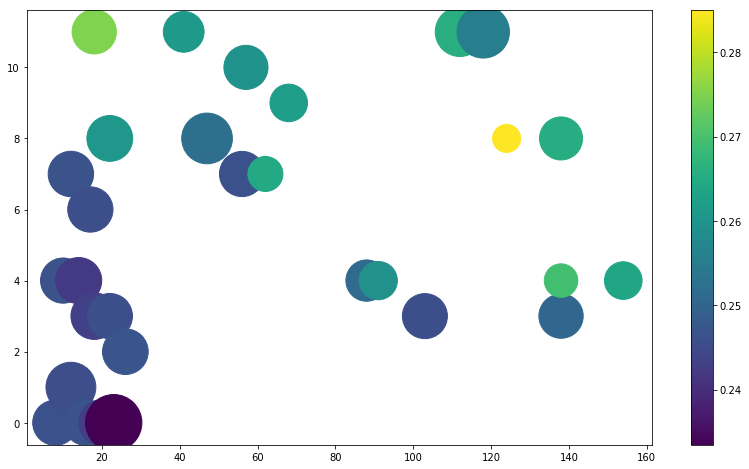

In [16]:
print(Runs[Runs['MSE'] == Runs['MSE'].min()])
plt.figure()
plt.scatter(Runs["N"],Runs['T'],s=1/Runs['STD']*100,c=Runs['MSE'])
plt.colorbar()
# plt.legend()